# BIDIRECTIONAL CLSTM (vs LSTM)- EMOVO

In [1]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from keras.layers import Layer

from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)



# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import shuffle
from joblib import dump, load

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import wave  
import warnings
from pydub import AudioSegment
from pydub.playback import play
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar



#### **1. Dataset Loading and Preparation**

In [3]:
Emotion = {'dis' : 'Disgust', 'gio':'Happy', 'pau' : 'Fear', 'rab' : 'Anger' , 'tri':'Sad', 'sor':'Surprise', 'neu' : 'Neutral'}

In [4]:
data = {'path':[],
        'labels':[]}
EMOVO_df = pd.DataFrame(data)
EMOVO_df

,path,labels


In [5]:
EMOVO = '/Users/gaetanopalmieri/virtualenvs/Università/PROGETTO_SMA/DATASET/archive/EMOVO/'
path_s = '/Users/gaetanopalmieri/virtualenvs/Università/PROGETTO_SMA/EMOVO/'

for sub_directory in os.listdir(EMOVO):
    direc = os.path.join(EMOVO,sub_directory)
    if sub_directory == 'documents':
        pass
    elif sub_directory == '.DS_Store':
        pass
    else:
        for file in os.listdir(direc):
            if sub_directory == 'm1':
                emotion = file.split('-')[0]
                f = os.path.join(direc,file)
                EMOVO_df.loc[len(EMOVO_df.index)] = [f, Emotion[emotion]]
            elif sub_directory == 'm2':
                emotion = file.split('-')[0]
                f = os.path.join(direc,file)
                EMOVO_df.loc[len(EMOVO_df.index)] = [f, Emotion[emotion]]
            elif sub_directory == 'm3':
                emotion = file.split('-')[0]
                f = os.path.join(direc,file)
                EMOVO_df.loc[len(EMOVO_df.index)] = [f, Emotion[emotion]]
            else:
                emotion = file.split('-')[0]
                f = os.path.join(direc,file)
                EMOVO_df.loc[len(EMOVO_df.index)] = [f, Emotion[emotion]]

In [6]:
EMOVO_df

,path,labels
0,/Users/gaetanopalmieri/virtualenvs/Università/...,Anger
1,/Users/gaetanopalmieri/virtualenvs/Università/...,Disgust
2,/Users/gaetanopalmieri/virtualenvs/Università/...,Anger
3,/Users/gaetanopalmieri/virtualenvs/Università/...,Anger
4,/Users/gaetanopalmieri/virtualenvs/Università/...,Disgust
...,...,...
583,/Users/gaetanopalmieri/virtualenvs/Università/...,Happy
584,/Users/gaetanopalmieri/virtualenvs/Università/...,Fear
585,/Users/gaetanopalmieri/virtualenvs/Università/...,Happy
586,/Users/gaetanopalmieri/virtualenvs/Università/...,Anger


In [7]:
print("Il numero dei samples è :", EMOVO_df.shape[0], "  -  Il numero delle classi è :", len(EMOVO_df.labels.unique()))

Il numero dei samples è : 588   -  Il numero delle classi è : 7


In [8]:
NEMOVO = EMOVO_df.labels.value_counts()
NEMOVO

Anger       84
Disgust     84
Surprise    84
Fear        84
Happy       84
Neutral     84
Sad         84
Name: labels, dtype: int64

### **1. LSTM**

In [ ]:
def extract_features(y,sr):

    '''
        >   chromagram
        >   root mean square error
        >   spectrel centroid
        >   spectral flatness
        >   spectral bandwidth
        >   spectral roll-off
        >   zero crossing rate
        >   mel-frequency cepstral coefficients (MFCCs)
    '''

    result = np.array([])

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30)

    result = np.hstack((np.mean(chroma_stft,axis=1), np.mean(rmse), np.mean(spec_cent),
                        np.mean(flatness), np.mean(spec_bw), np.mean(rolloff),
                        np.mean(zcr), np.mean(mfcc, axis=1)))

    return result


def get_features(path, noise: bool, stretch_pitch: bool, shift: bool):

    y, sr = librosa.load(path, sr=48000)

    # feature extraction without augmentation
    res1 = extract_features(y,sr)
    result = np.array(res1)

    # data con noise
    if (noise==True):
        noise_data = Noise(y)
        res2 = extract_features(noise_data, sr)
        result = np.vstack((result, res2)) # stacking v

    # data con stretching and pitching
    if (stretch_pitch==True):
        new_data = Stretch(y)
        data_stretch_pitch = Pitch(new_data, sr)
        res3 = extract_features(data_stretch_pitch, sr)
        result = np.vstack((result, res3)) # stacking v

    # data con shift
    if (shift==True):
        shift_data = Stretch(y)
        res4 = extract_features(shift_data, sr)
        result = np.vstack((result, res4)) # stacking v

    return result

def store_features(audio_path: pd.core.frame.DataFrame, emotion: pd.core.frame.DataFrame,
                   noise: bool=False, stretch_pitch: bool=False, shift: bool=False):

    X, Y = [], []
    for path, emotion in zip(audio_path, emotion):
        # extracting features
        features = get_features(path, noise, stretch_pitch, shift)
        # storing the results and the corresponding emotion
        for ele in features:
            X.append(ele)
            Y.append(emotion)

    # Store results as DataFrame
    features_df = pd.DataFrame(X)
    features_df['labels'] = Y

    return features_df

def data_preparation(data: pd.core.frame.DataFrame, Y_col: int=-1,
                    standard_scaler: bool=True, one_hot_encoding: bool=False,
                    train_test: bool=True, split_rate: float=0.8,
                    cv: bool=False, n_fold: int=5,
                    shuffle: bool=True):

                    '''

                    Parameters:
                    > data: data come DataFrame
                    > Y_col: column index number of labels (default is -1)
                    > StandardScaler: if True (default) data has to be standardized through the StandardScaler
                    > OneHotEncoder: if True (default is False) labels have to be one-hot-encoded
                    > train_test: if True (default) the dataset has to be split in train and test set
                    > test_size: it determines the size of the train test with respect to the whole dataset (default is 0.8)
                    > cv: if True (default is False) K-Folds cross-validator object is created
                    > n_fold: number of splitting iterations in the cross-validator
                    > shuffle: Whether to shuffle the data during train_test_split and cross_validation (default is True)
                    '''

                    Y = data.iloc[:,Y_col].values
                    X = data.iloc[: ,:-1].values
                    kf = None
                    encoder = None

                    if standard_scaler==True:
                        scaler = StandardScaler()
                        X = scaler.fit_transform(X)

                    if one_hot_encoding==True:
                        encoder = OneHotEncoder()
                        Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
                        dump(encoder, 'encoder.joblib')

                    if train_test==True:
                        x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0,
                                                                            shuffle = shuffle,
                                                                            train_size = split_rate)
                        if cv==True:
                            kf = KFold(n_splits=n_fold, shuffle=shuffle, random_state=None)

                        pd.DataFrame(x_train).to_csv('x_train.csv', index=False)
                        pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
                        pd.DataFrame(x_test).to_csv('x_test.csv', index=False)
                        pd.DataFrame(y_test).to_csv('y_test.csv', index=False)
                        return x_train, x_test, y_train, y_test, kf
                    else:
                        if cv==True:
                            kf = KFold(n_splits=n_fold, shuffle=shuffle, random_state=None)

                        X.to_csv('X.csv', index=False)
                        Y.to_csv('Y.csv', index=False)
                        return X, Y, kf

def label_manager(data: pd.core.frame.DataFrame, Y_col: int=-1,
                 delate: list=[], rename: dict={}):
    '''Managing labels of a DataFrame.
    Parameters:
    > data: data as DataFrame
    > Y_col: column index number of labels (default is -1)
    > delate: list of labels to be removed
    > rename: dictionary of labels to be replaced with new names
    '''

    # Select labels
    Y = data.iloc[:,Y_col]

    # Delate rows with unwanted labels
    if len(delate)!=0 :
        for label_del in delate:
            data = data[Y!=label_del]

    # Rename labels according to the dictionary passed as parameter
    if len(rename)!=0:
        data.labels.replace(rename, inplace=True)

    return data


In [33]:
from lstm import LSTMClassif

def cross_validation(X, Y, kf):
    acc_per_fold =[]
    loss_per_fold =[]
    fold=1
    for train_idx, val_idx in kf.split(X,Y):
        classifier = LSTMClassif(n_class=Y.shape[1], input_shape=(X[train_idx].shape[1], 1))
        classifier.build()
        classifier.fit(X=X[train_idx], Y=Y[train_idx],
                        val_data=(X[val_idx], Y[val_idx]), epochs=100,
                        callbacks=True)
        scores = classifier.eval(X=X[val_idx], Y=Y[val_idx])
        print(f'Score for fold {fold}:\
            {classifier.model.metrics_names[0]} of {scores[0]};\
            {classifier.model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        fold = fold + 1
    acc = np.mean(acc_per_fold)
    loss = np.mean(loss_per_fold)
    print('Accuracy of Model with ({}-Fold) Cross Validation is: {:.2f} %'.format(kf.n_splits,acc))
    print('Loss of Model with ({}-Fold) Cross Validation is: {:.4f}'.format(kf.n_splits,loss))
    classifier.save(path ='', name='trained_model')


In [34]:
data = pd.read_csv('EMOVO_features.csv')
x_train, x_test, y_train, y_test, kf = data_preparation(data, standard_scaler=True, one_hot_encoding=True,
                                                        train_test=True, split_rate=0.75, cv=True, n_fold=5)
cross_validation(x_train, y_train, kf)

Epoch 1/100
34/34 [==============================] - 14s 297ms/step - loss: 2.2540 - accuracy: 0.1361 - val_loss: 1.9583 - val_accuracy: 0.1774
Epoch 2/100
34/34 [==============================] - 10s 282ms/step - loss: 1.9554 - accuracy: 0.1749 - val_loss: 1.9307 - val_accuracy: 0.2113
Epoch 3/100
34/34 [==============================] - 9s 276ms/step - loss: 1.9473 - accuracy: 0.1626 - val_loss: 1.9292 - val_accuracy: 0.2189
Epoch 4/100
34/34 [==============================] - 11s 318ms/step - loss: 1.9453 - accuracy: 0.1673 - val_loss: 1.9892 - val_accuracy: 0.1208
Epoch 5/100
34/34 [==============================] - 12s 338ms/step - loss: 1.9353 - accuracy: 0.1767 - val_loss: 1.9226 - val_accuracy: 0.1811
Epoch 6/100
34/34 [==============================] - 11s 331ms/step - loss: 1.9064 - accuracy: 0.2136 - val_loss: 1.8732 - val_accuracy: 0.2528
Epoch 7/100
34/34 [==============================] - 11s 323ms/step - loss: 1.8764 - accuracy: 0.1966 - val_loss: 1.8236 - val_accuracy: 

INFO:tensorflow:Assets written to: ram://8514eaaa-23ec-4695-8b1e-69e8f9629a16/assets


INFO:tensorflow:Assets written to: ram://8514eaaa-23ec-4695-8b1e-69e8f9629a16/assets


### **2. BIDIRECTIONAL CLSTM Bidirezionale : MelSpectogram Extraction from Sequetial Data**


In [9]:
# Preprocessing parameters
sr = 44100  # Sampling rate
duration = 7
hop_length = 347  # to make time steps 128
fmin = 20
fmax = sr // 2
n_mels = 128
n_fft = n_mels * 20
samples = sr * duration


def read_audio(path):
    '''
    Reads in the audio file and returns
    an array that we can turn into a melspectogram
    '''
    y, _ = librosa.core.load(path, sr=44100)
    # trim silence
    if 0 < len(y):  # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples:  # long enough
        y = y[0:0 + samples]
    else:  # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y


def audio_to_melspectrogram(audio):
    '''
    Convert to melspectrogram after audio is read in
    '''
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=sr,
                                                 n_mels=n_mels,
                                                 hop_length=hop_length,
                                                 n_fft=n_fft,
                                                 fmin=fmin,
                                                 fmax=fmax)
    return librosa.power_to_db(spectrogram).astype(np.float32)


def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram
    so we can use machine learning
    '''
    mels = audio_to_melspectrogram(read_audio(path))
    return mels


def convert_wav_to_image(df, path):
    X = []
    for _, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram('{}/{}'.format(path[0], str(row['path'])))
        X.append(x.transpose())
    return X


def normalize(img):
    '''
    Normalizes an array
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img


def normalize_dataset(X):
    '''
    Normalizes list of arrays
    (subtract mean and divide by standard deviation)
    '''
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset


In [10]:
path = '/Users/gaetanopalmieri/virtualenvs/Università/PROGETTO_SMA/EMOVO/Emovo_data.csv'
X = np.array(convert_wav_to_image(EMOVO_df, path))
X = normalize_dataset(X)
Y = EMOVO_df.labels.values
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=32)

/var/folders/bb/h1j5r_2d0s55rtj_m315_4cr0000gn/T/ipykernel_15645/2872915887.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, row in tqdm_notebook(df.iterrows()):


0it [00:00, ?it/s]

/var/folders/bb/h1j5r_2d0s55rtj_m315_4cr0000gn/T/ipykernel_15645/2872915887.py:34: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
/var/folders/bb/h1j5r_2d0s55rtj_m315_4cr0000gn/T/ipykernel_15645/2872915887.py:34: FutureWarning: Pass y=[ 6.7025453e-06 -2.1631963e-04  3.9414471e-04 ... -7.7862211e-02
 -8.5835278e-02 -8.8092357e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
/var/folders/bb/h1j5r_2d0s55rtj_m315_4cr0000gn/T/ipykernel_15645/2872915887.py:34: FutureWarning: Pass y=[-8.4760354e-04 -1.7086910e-04 -2.2560866e-04 ...  7.0577502e-05
 -4.0506280e-04 -3.9608422e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
/var/folders/b

In [11]:
from keras import backend as K

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None
                 ,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [12]:
from tensorflow.keras.optimizers import Adam
from keras.layers import (Dense, Bidirectional, CuDNNLSTM, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.models import Sequential
from keras.callbacks import EarlyStopping

input_shape = (890,128)
optimizer = Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True)
n_classes = 7

model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape))
model.add(Attention(890))
model.add(Dropout(0.2))
model.add(Dense(400))
model.add(ELU())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

2022-05-15 17:22:15.513492: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=30)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_val = (x_val - mean)/std
hist = model.fit(np.array(x_train),
          y_train,
          batch_size=64,
          epochs=500,
          validation_data=(np.array(x_val), y_val),
          callbacks = [es])

Epoch 1/500
9/9 [==============================] - 53s 5s/step - loss: 2.8409 - acc: 0.1701 - val_loss: 2.6553 - val_acc: 0.1186
Epoch 2/500
9/9 [==============================] - 51s 6s/step - loss: 2.0567 - acc: 0.2344 - val_loss: 2.1997 - val_acc: 0.2542
Epoch 3/500
9/9 [==============================] - 49s 5s/step - loss: 1.7700 - acc: 0.2987 - val_loss: 1.7715 - val_acc: 0.3051
Epoch 4/500
9/9 [==============================] - 50s 6s/step - loss: 1.5843 - acc: 0.3705 - val_loss: 1.7432 - val_acc: 0.2712
Epoch 5/500
9/9 [==============================] - 60s 7s/step - loss: 1.3928 - acc: 0.4575 - val_loss: 1.3558 - val_acc: 0.4576
Epoch 6/500
9/9 [==============================] - 68s 8s/step - loss: 1.4465 - acc: 0.4178 - val_loss: 1.3213 - val_acc: 0.5254
Epoch 7/500
9/9 [==============================] - 49s 5s/step - loss: 1.2654 - acc: 0.5180 - val_loss: 1.3113 - val_acc: 0.4068
Epoch 8/500
9/9 [==============================] - 47s 5s/step - loss: 1.0233 - acc: 0.6257 - val

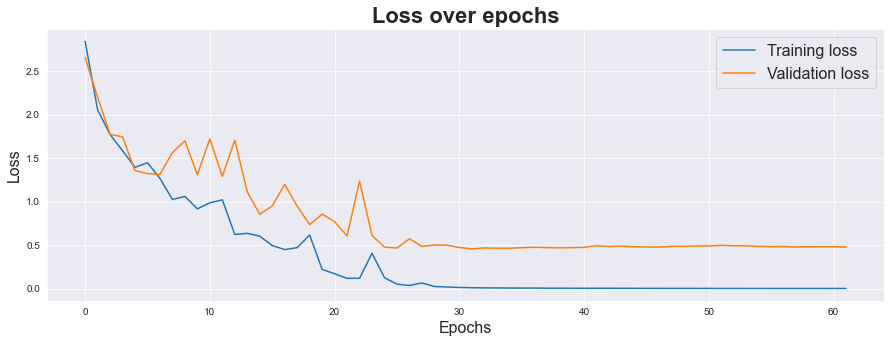

In [18]:
# Visualize loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']
stopped_epoch = es.stopped_epoch
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()

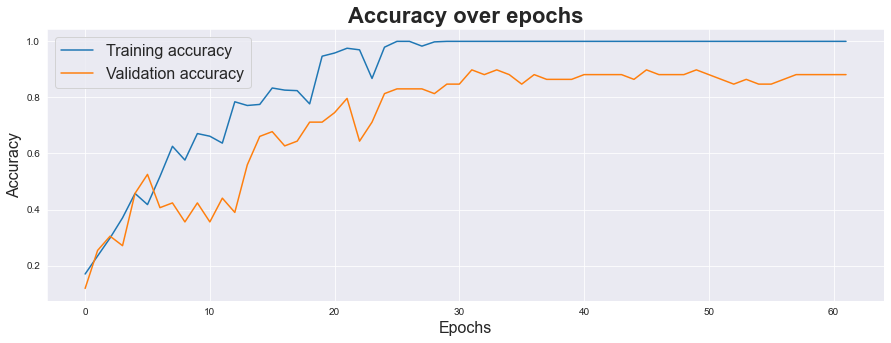

In [19]:
# Visualize Accuracy
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

In [20]:
scores = model.evaluate(x_val, y_val)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 3s 1s/step - loss: 0.4772 - acc: 0.8814
acc: 88.14%


4/4 - 3s - 3s/epoch - 798ms/step


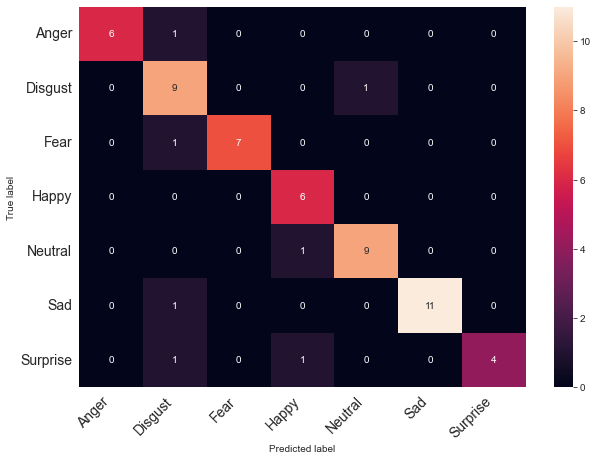

In [21]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_results(X_test, y_test, labels, model):
        preds = model.predict(X_test,
                                 batch_size=16,
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)

confusion_results(x_val, y_val, EMOVO_df.labels.unique(), model)

**FINAL RESULTS**

Metric: Accuracy

**LSTM -> 67%**

**BIDIRECTIONAL CLSTM -> 88%**

Enjoy :)